<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/Seq_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title rohanpandey WISDM
# https://github.com/rohanpandey/Analysis--WISDM-Smartphone-and-Smartwatch-Activity/blob/master/dataset_creation.ipynb
! wget https://archive.ics.uci.edu/static/public/507/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip
!unzip wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip
!unzip wisdm-dataset.zip

import os
import glob
import pandas as pd

folder1=glob.glob("wisdm-dataset/raw/*")
# print(folder1)
column_names = ['ID', 'activity','timestamp','x','y','z']
overall_dataframe=pd.DataFrame(columns = column_names)
for subfolder in folder1:
    parent_dir = "./processed/"
    path = os.path.join(parent_dir, subfolder.split('\\')[-1])
    if not os.path.exists(path): os.makedirs(path)
    folder2=glob.glob(subfolder+"/*")
    for subsubfolder in folder2:
        activity_dataframe = pd.DataFrame(columns = column_names)
        subfolder_path = os.path.join(path, subsubfolder.split('/')[-1])
        if not os.path.exists(subfolder_path): os.makedirs(subfolder_path)
        files=glob.glob(subsubfolder+"/*")
        for file in files:
            # print(file)
            df = pd.read_csv(file, sep=",",header=None)
            df.columns = ['ID','activity','timestamp','x','y','z']
            # activity_dataframe=activity_dataframe.append(df)
            activity_dataframe = pd.concat([activity_dataframe, df], ignore_index=True)

        activity_dataframe['z']=activity_dataframe['z'].str[:-1]
        # activity_dataframe['meter']=subsubfolder.split('/')[-1]
        # activity_dataframe['device']=subfolder.split('/')[-1]
        activity_dataframe.to_csv(subfolder_path+'/data.csv',index=False)


In [ ]:
# @title wisdm dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd

# /content/processed/wisdm-dataset/raw/phone/accel/data.csv
# /content/processed/wisdm-dataset/raw/watch/gyro/data.csv

class BufferDataset(Dataset):
    def __init__(self):
        # df_keep = pd.read_csv("data.csv")#[['ID','activity','timestamp','x','y','z']]
        df_keep = pd.read_csv("/content/processed/wisdm-dataset/raw/watch/accel/data.csv")

        user_acts = dict(tuple(df_keep.groupby(['ID','activity'])[['timestamp','x','y','z']]))
        self.data = [[d.to_numpy(), a] for a, d in user_acts.items()]
        self.act_dict = {i: act for i, act in enumerate(df_keep['activity'].unique())}
        self.act_invdict = {v: k for k, v in self.act_dict.items()} # {'A': 0, 'B': 1, ...

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, id_act = self.data[idx]
        id_act = self.process(id_act)
        return torch.tensor(x[:3500]), id_act # 3567

    def process(self, id_act):
        return int(id_act[0]), self.act_invdict[id_act[1]]

    def transform(self, act_list): # rand resize crop, rand mask # https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html
        act_list = np.array(act_list)
        try: hr, temp, heart= zip(*act_list)
        except ValueError: print('err:',act_list)
        kind = 'nearest' if len(act_list)>self.seq_len/.7 else 'linear'
        temp_interpolator = scipy.interpolate.interp1d(hr, temp, kind=kind) # linear nearest quadratic cubic
        heart_interpolator = scipy.interpolate.interp1d(hr, heart, kind=kind) # linear nearest quadratic cubic
        hr_ = np.sort(np.random.uniform(hr[0], hr[-1], round(self.seq_len*random.uniform(1,1/.7))))
        temp_, heart_ = temp_interpolator(hr_), heart_interpolator(hr_)
        act_list = list(zip(hr_, temp_, heart_))

        idx = torch.randint(len(act_list)-self.seq_len+1, size=(1,))
        # return act_list[idx: idx+self.seq_len]
        act_list = act_list[idx: idx+self.seq_len]

        # mask=(torch.rand(self.seq_len)<.1) # True -> masked # random masking
        # # act_list[mask] = self.pad[0]
        # act_list = [self.pad[0] if m else a for m,a in zip(mask, act_list)]
        return act_list

    def add(self, episode):
        self.data.append(episode)

import numpy as np
from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(3, 3))
    # print(npimg.shape) # (3, 64, 64)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# df_keep = pd.read_csv("data.csv")#[['ID','activity','timestamp','x','y','z']]
# user_acts = dict(tuple(df_keep.groupby(['ID','activity'])[['timestamp','x','y','z']]))
# dataset = [[d.to_numpy(), a] for a, d in user_acts.items()]


train_data = BufferDataset() # one line of poem is roughly 50 characters

dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(0.7 * dataset_size))
np.random.seed(0)
np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]

from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

from torch.utils.data.dataloader import DataLoader
batch_size = 64 #512
# train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
# test_loader = DataLoader(train_data, sampler=valid_sampler, batch_size=batch_size, num_workers=2, drop_last=True)
train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)


In [ ]:
# @title tsai
# https://timeseriesai.github.io/tsai/
!pip install -qU tsai # 3mins
import tsai
from tsai.data.external import get_UCR_data, get_UCR_multivariate_list

# l = get_UCR_multivariate_list()
# print(len(l), l)
# X_train, y_train, X_valid, y_valid = get_UCR_data(dsid) # tsai


In [2]:
# @title tslearn
!pip install -qU tslearn
from tslearn.datasets import UCR_UEA_datasets # https://tslearn.readthedocs.io/en/latest/gen_modules/datasets/tslearn.datasets.UCR_UEA_datasets.html

# l = UCR_UEA_datasets().list_datasets() # 30 ['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'EthanolConcentration', 'ERing', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PenDigits', 'PEMS-SF', 'Phoneme', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']
# l = UCR_UEA_datasets().list_multivariate_datasets() # same ^
# l = UCR_UEA_datasets().list_univariate_datasets() # 0 []
# print(len(l), l)

# for dataset_name in data_loader.list_datasets(): # 30 ['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'EthanolConcentration', 'ERing', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PenDigits', 'PEMS-SF', 'Phoneme', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']
#     X_train, y_train, X_test, y_test = data_loader.load_dataset(dataset_name)

# X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('AtrialFibrillation') # tslearn



In [ ]:
# @title sktime
!pip install -q sktime
from sktime.datasets import load_UCR_UEA_dataset
import numpy as np
# https://www.sktime.net/en/v0.32.2/examples/AA_datatypes_and_datasets.html#Section-3.2.3:-time-series-classification-data-sets-from-the-UCR/UEA-time-series-classification-repository

X_train, y_train = load_UCR_UEA_dataset('AtrialFibrillation')
X_train, y_train = load_UCR_UEA_dataset('AtrialFibrillation', split="train")
X_test, y_test = load_UCR_UEA_dataset('AtrialFibrillation', split="test")

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

# X_train and X_test will typically be Pandas DataFrames or NumPy arrays
# y_train and y_test will be NumPy arrays or Pandas Series

# print(X_train, y_train)
# print(X_train[0], y_train[0])
# print(X_train)
print(X_train.iloc[0])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.3 MB/s eta 0:00:00
Training data shape: (15, 2)
Training labels shape: (15,)
Testing data shape: (15, 2)
Testing labels shape: (15,)
dim_0    0     -0.34086
1     -0.38038
2     -0.34580
3...
dim_1    0      0.14820
1      0.13338
2      0.10868
3...
Name: 0, dtype: object


In [ ]:
# @title test load all datasets
l = get_UCR_multivariate_list()
print(len(l), l)
for i, dataset_name in enumerate(get_UCR_multivariate_list()):
# for dataset_name in get_UCR_multivariate_list()[15:20]:
    print(dataset_name)
    # if dataset_name in ['DuckDuckGeese','FaceDetection','InsectWingbeat','PEMS-SF']:
    #     print('skip', dataset_name)
    #     continue
    # try: X_train, y_train, X_valid, y_valid = get_UCR_data(dataset_name) # tsai
    # # InsectWingbeat, PEMS-SF slow

    # if dataset_name in ['AtrialFibrillation', 'CharacterTrajectories','DuckDuckGeese','EigenWorms','ERing','InsectWingbeat','JapaneseVowels','SpokenArabicDigits']:
    # # EigenWorms slow
    #     print('skip', dataset_name)
    #     continue
    # try: X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset_name) # tslearn

    if dataset_name in ['InsectWingbeat']:
        print('skip', dataset_name)
        continue
    try:
        X_train, y_train = load_UCR_UEA_dataset(dataset_name)
        X_train, y_train = load_UCR_UEA_dataset(dataset_name, split="train")
        X_test, y_test = load_UCR_UEA_dataset(dataset_name, split="test")
    # InsectWingbeat slow oom

    # who has DuckDuckGeese','FaceDetection','InsectWingbeat


    except Exception as e: print(e); continue
    print(dataset_name, X_train.shape)


30 ['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'ERing', 'EthanolConcentration', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PEMS-SF', 'PenDigits', 'PhonemeSpectra', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']
InsectWingbeat
skip InsectWingbeat
JapaneseVowels
JapaneseVowels (270, 12)
Libras
Libras (180, 2)
LSST
LSST (2459, 6)
MotorImagery
MotorImagery (278, 64)


In [3]:
# @title time series DataLoader
import torch
from torch.utils.data import Dataset, DataLoader

dataset_name = 'EthanolConcentration'
# X_train, y_train, X_test, y_test = get_UCR_data(dataset_name) # tsai
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset_name) # tslearn


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        chars = sorted(list(set(y)))
        self.vocab_size = len(chars) #
        self.stoi = {ch:i for i,ch in enumerate(chars)}
        self.itos = {i:ch for i,ch in enumerate(chars)}
        self.X = torch.tensor(X) # (N, 1, T)
        self.y = self.data_process(y) #

    def data_process(self, data): # str
        return torch.tensor([self.stoi.get(c) for c in data]) #
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_data = TimeSeriesDataset(X_train, y_train)
test_data = TimeSeriesDataset(X_test, y_test)
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

# print(X_train, y_train, X_test, y_test)
# for x,y in train_loader:
# # for x,y in train_data:
#     print(x.shape, y.shape) # (261, 1751, 3)
#     print(x, y)
#     break

# print(x.shape[-1])
# print(X_train.shape[-1])
# print(train_data.vocab_size) # 4


In [ ]:
# @title plot data
# print(X_train, y_train, X_test, y_test)
# for x,y in train_loader:
# for x,y in train_data:
for i, (x,y) in enumerate(train_data):
    # print(x.shape, y.shape)
    # print(x, y)
    # break
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (8,4)
    # plt.plot(x[:,0])
    for j in range(x.shape[-1]):
        plt.plot(x[:,j])
    plt.show()
    if i>=3: break

# print(x.shape[-1])
# print(X_train.shape[-1])
# print(train_data.vocab_size)



In [4]:
# @title AttentionBlock
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class SelfAttn(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.dim, self.n_heads = dim, n_heads
        d_head = dim//n_heads
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        # self.lin = nn.Linear(dim, dim)
        self.lin = zero_module(nn.Linear(dim, dim))
        # self.rope = RoPE(d_head, seq_len=512, base=10000)
        # self.rope = RoPE2D(d_head, h=64, w=64, base=100)
        self.scale = d_head**-.5

    def forward(self, x): # [b,t,d]
        q,k,v = self.qkv(x).unflatten(-1, (self.n_heads,-1)).transpose(1,2).chunk(3, dim=-1) # [b, t, n_heads, d_head] -> [b, n_heads, t, d_head]
        # q, k = self.rope(q), self.rope(k)
        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        x = q @ context # [b, n_heads, t, d_head]
        # print('SelfAttn', x.shape)
        x = x.transpose(1,2).flatten(2)
        return self.lin(x)

class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, mult=4, drop=0.):
        super().__init__()
        self.d_model = d_model
        # self.norm = nn.RMSNorm(d_model, elementwise_affine=False) # LayerNorm RMSNorm
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.drop = nn.Dropout(drop)
        self.attn = SelfAttn(d_model, n_heads)
        act = nn.GELU() # ReLU GELU
        ff_dim=d_model*mult
        self.ff = nn.Sequential(
            # nn.RMSNorm(d_model), act, nn.Dropout(drop), nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Dropout(drop), zero_module(nn.Linear(ff_dim, d_model))
            nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), act,
            # nn.RMSNorm(d_model), nn.Dropout(drop), nn.Linear(d_model, ff_dim), act,
            nn.RMSNorm(ff_dim), nn.Dropout(drop), zero_module(nn.Linear(ff_dim, d_model))
        )


    def forward(self, x): # [batch, seq_len, d_model]
        # print('attnblk fwd',x.shape)
        x = x + self.drop(self.attn(self.norm1(x)))
        x = x + self.ff(x)
        # x = x + self.drop(self.ff(self.norm2(x)))
        return x


In [ ]:
# @title simplex
!pip install -q opensimplex
import opensimplex
import numpy as np
import torch
import matplotlib.pyplot as plt

def simplexmask1d(seq=512, ctx_scale=(.85,1), trg_scale=(.6,.8), B=64, chaos=[1,.5]):
    i = np.linspace(0, chaos[0], num=seq) # 2-5
    noise = opensimplex.noise2array(i, np.random.randint(1e10, size=B)) # [B, seq]
    noise = torch.from_numpy(noise)
    # trunc_normal = torch.fmod(torch.randn(2)*.3,1)/2 + .5
    # print(trunc_normal)
    ctx_mask_scale = torch.rand(1) * (ctx_scale[1] - ctx_scale[0]) + ctx_scale[0] # in (min_s, max_s) # all blocks same size
    trg_mask_scale = torch.rand(1) * (trg_scale[1] - trg_scale[0]) + trg_scale[0]
    # ctx_mask_scale = trunc_normal[0] * (ctx_scale[1] - ctx_scale[0]) + ctx_scale[0] # in (min_s, max_s) # all blocks same size
    # trg_mask_scale = trunc_normal[1] * (trg_scale[1] - trg_scale[0]) + trg_scale[0]

    ctx_len, trg_len = int(seq*ctx_mask_scale), int(seq*trg_mask_scale)
    val, trg_index = torch.topk(noise, trg_len, dim=1, sorted=False)
    ctx_len = ctx_len - trg_len

    remove_mask = torch.ones((B,seq), dtype=bool) # [B, S]
    remove_mask.scatter_(1, trg_index, False).flatten()
    ind = torch.arange(seq).unsqueeze(0).repeat(B,1)[remove_mask].reshape(B, -1)

    i = np.linspace(0, chaos[1], num=seq) # 2-5
    noise = opensimplex.noise2array(i, np.random.randint(1e10, size=B)) # [B, seq]
    noise = torch.from_numpy(noise)[remove_mask].reshape(B, -1)
    val, ctx_ind = torch.topk(noise, ctx_len, dim=1, sorted=False)
    ctx_index = ind[torch.arange(B).unsqueeze(-1), ctx_ind]
    return ctx_index, trg_index

b=64
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.7,.8), trg_scale=(.4,.6), B=b, chaos=[3,.5])
ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.85,1), trg_scale=(.7,.8), B=b, chaos=[3,.5])
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.8,.9), trg_scale=(.7,.8), B=b, chaos=[1,.5])
mask = torch.zeros(b ,200)
mask[torch.arange(b).unsqueeze(-1), trg_index] = 1
mask[torch.arange(b).unsqueeze(-1), ctx_index] = .5
# mask = mask[None,...]
# mask = mask[:,None,None,:]#.repeat(1,3,1,1)
print(mask.shape)

# def imshow(img):
#     npimg = img.numpy()
#     plt.rcParams["figure.figsize"] = (8,4)
#     # plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.pcolormesh(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
# # imshow(mask[0])
# import torchvision
# imshow(torchvision.utils.make_grid(mask, nrow=1))

# print(index)
# print(index.shape)
# print(mask)
# print(mask.shape)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 7.3 MB/s eta 0:00:00
torch.Size([64, 200])


In [ ]:
trunc_normal = torch.fmod(torch.randn(100),1)/2 + .5
print(trunc_normal)

In [5]:
# @title ijepa multiblock 1d
# https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
import torch

class MaskCollator(object):
    def __init__(self, length=200,
        enc_mask_scale=(0.2, 0.8), pred_mask_scale=(0.2, 0.8),
        nenc=1, npred=2, min_keep=4, allow_overlap=False):
        super().__init__()
        self.length = length
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.nenc = nenc
        self.npred = npred
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks

    def _sample_block_size(self, scale):
        _rand = torch.rand(1).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.length * mask_scale) # num patches to keep
        # -- Sample block aspect-ratio
        # -- Compute block height and width (given scale and aspect-ratio)
        l = max_keep#int(round(math.sqrt(max_keep * aspect_ratio)))
        while l >= self.length: l -= 1 # crop mask to be smaller than img
        return l

    def _sample_block_mask(self, length, acceptable_regions=None):
        l = length
        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # --
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            # -- Sample block top-left corner
            left = torch.randint(0, self.length - l, (1,))
            mask = torch.zeros(self.length, dtype=torch.int32)
            mask[left:left+l] = 1
            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones(self.length, dtype=torch.int32)
        mask_complement[left:left+l] = 0
        # --
        return mask, mask_complement

    def __call__(self, B):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        p_size = self._sample_block_size(scale=self.pred_mask_scale)
        e_size = self._sample_block_size(scale=self.enc_mask_scale)

        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.length
        min_keep_enc = self.length
        for _ in range(B):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            try:
                if self.allow_overlap:
                    acceptable_regions= None
            except Exception as e:
                print(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)
        collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        # --
        collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)
        return collated_masks_enc, collated_masks_pred

batch=64
length=200
mask_collator = MaskCollator(length=length, enc_mask_scale=(.85, 1.), pred_mask_scale=(.15, .2),
        nenc=1, npred=4, min_keep=4,
        # allow_overlap=True)
        allow_overlap=False)

collated_masks_enc, collated_masks_pred = mask_collator(batch)
context_indices, trg_indices = torch.stack(collated_masks_enc).squeeze(0), torch.stack(collated_masks_pred).transpose(0,1).flatten(1).unique(dim=1) # [num_msk, b,num_tok]->[b,num_tok] # [64, 65], [64, 32]
# print(context_indices.shape, trg_indices.shape)


# plt.pcolormesh(mask)
b=64
mask = torch.zeros(batch ,length)
mask[torch.arange(batch).unsqueeze(-1), trg_indices] = 1
mask[torch.arange(batch).unsqueeze(-1), context_indices] = .5
# mask = mask[None,...]
# print(mask.shape)
# mask = mask[:,None,None,:]#.repeat(1,3,1,1)
# print(mask.shape)

# import numpy as np
# import matplotlib.pyplot as plt
# def imshow(img):
#     npimg = img.numpy()
#     plt.rcParams["figure.figsize"] = (8,4)
#     # plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.pcolormesh(np.transpose(npimg, (1, 2, 0)))
#     # plt.imshow(npimg)
#     plt.show()
# # imshow(mask)
# import torchvision
# print(torchvision.utils.make_grid(mask, nrow=1).shape)
# # imshow(torchvision.utils.make_grid(mask, nrow=8))
# imshow(torchvision.utils.make_grid(mask, nrow=1))



## visualise mask distribution

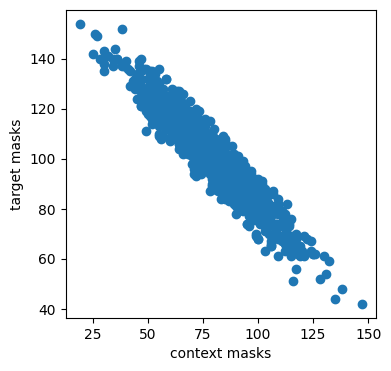

In [ ]:
plt.rcParams["figure.figsize"] = (4,4)
# plt.plot(ttc,ttt)
plt.scatter(ttc,ttt)
plt.xlabel('context masks')
plt.ylabel('target masks')

plt.show()

35.525 149.368


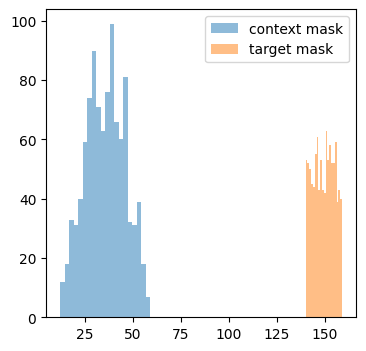

In [ ]:
ttc=[]
ttt=[]
def mean(x): return sum(x)/len(x)

for i in range(1000):
    # collated_masks_enc, collated_masks_pred = mask_collator(1)
    # context_indices, trg_indices = torch.stack(collated_masks_enc).squeeze(0), torch.stack(collated_masks_pred).transpose(0,1).flatten(1).unique(dim=1) # [num_msk, b,num_tok]->[b,num_tok] # [64, 65], [64, 32]
    # context_indices, trg_indices = simplexmask1d(seq=200, ctx_scale=(.8,1), trg_scale=(.2,.8), B=1, chaos=[3,.5])
    context_indices, trg_indices = simplexmask1d(seq=200, ctx_scale=(.85,1), trg_scale=(.7,.8), B=1, chaos=[1,.5])
    ttc.append(context_indices.shape[-1])
    ttt.append(trg_indices.shape[-1])

print(mean(ttc), mean(ttt))

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)
plt.hist(ttc, bins=20, alpha=.5, label='context mask')
plt.hist(ttt, bins=20, alpha=.5, label='target mask')
plt.legend()
plt.show()

## bdnffdb

In [6]:
# @title RoPE
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def RoPE(dim, seq_len=512, base=10000):
    theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
    pos = torch.arange(seq_len).unsqueeze(-1)
    angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
    rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [1, seq_len, dim // 2, 2] -> [1, seq_len, dim]
    return rot_emb

# class RoPE(nn.Module): # Rotary Positional Embeddings
#     def __init__(self, dim, seq_len=512, base=10000):
#         super().__init__()
#         self.dim, self.base = dim, base
#         theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
#         pos = torch.arange(seq_len).unsqueeze(-1)
#         angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
#         self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [seq_len, dim // 2, 2] -> [1, seq_len, dim]

#     def forward(self, x):
#         seq_len = x.size(1)
#         if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len, self.base)
#         return x * self.rot_emb[:seq_len]

class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=10000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))
        # self.theta = top / (base ** torch.linspace(0, 1, dim//2, device=device))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2) # [seq_len, dim]


In [7]:
# @title TransformerModel/Predictor
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TransformerPredictor(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, n_heads=4, d_hid=None, nlayers=1, drop=0.):
        super().__init__()
        self.embed = nn.Linear(in_dim, d_model)# if in_dim != d_model else None
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        # self.pos_emb = nn.Parameter(torch.randn(1, 256, d_model)*.02) # 200
        self.pos_emb = RoPE(d_model, seq_len=2000, base=10000) # 256

        # self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads=n_heads) for _ in range(nlayers)])
        self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads=n_heads, drop=drop) for _ in range(nlayers)])

        self.cls = nn.Parameter(torch.randn(1,1,d_model)*0.02) # randn zeros
        out_dim = out_dim or d_model
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim)# if out_dim != d_model else None

    def forward(self, x, context_indices, trg_indices): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = x.shape
        # x = x * self.pos_enc(context_indices)
        # print("Trans pred",x.shape, self.pos_emb[0,context_indices].shape)
        x = x + self.pos_emb[0,context_indices]
        # x = x * self.pos_emb[0,context_indices]
        # print('pred fwd', self.pos_emb[:,context_indices].shape)

        # pred_tokens = self.cls * self.pos_enc(trg_indices) # [M, num_trg_toks, d_model]
        pred_tokens = self.cls + self.pos_emb[0,trg_indices]
        # pred_tokens = self.cls * self.pos_emb[0,trg_indices]
        # print("pred fwd", x.shape, pred_tokens.shape)
        x = torch.cat([x, pred_tokens], dim=1) # [batch, seq_len+num_trg_toks, d_model]
        out = self.transformer(x)

        out = self.norm(out)
        out = out[:,seq:] # [batch, num_trg_toks, d_model]
        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]


class TransformerModel(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, drop=0):
    def __init__(self, patch_size, in_dim, d_model, out_dim=None, n_heads=4, nlayers=1, drop=0):
        super().__init__()
        patch_size=8
        act = nn.ReLU() # ReLU SiLU GELU
        self.embed = nn.Sequential(
            # # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.MaxPool1d(2,2), #nn.MaxPool1d(3, 2, 3//2),
            # # nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.Conv1d(d_model, d_model,3,2,3//2)
            # nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), act, nn.MaxPool1d(2,2),
            # # nn.Conv1d(d_model, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            # nn.Conv1d(d_model, d_model,3,2,3//2),
            # nn.Conv1d(in_dim, d_model, patch_size, patch_size), # like patch
            nn.Conv1d(in_dim, d_model, 1, 1), # like patch

            # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.Dropout(drop), nn.BatchNorm1d(d_model), snake,
            # lstm

            )
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        # self.pos_emb = nn.Parameter(torch.randn(1, 256, d_model)*.02) # 200
        self.pos_emb = RoPE(d_model, seq_len=2000, base=10000) # 256
        # self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads=n_heads) for _ in range(nlayers)])
        self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads=n_heads, drop=drop) for _ in range(nlayers)])
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim) if out_dim and out_dim != d_model else None

    def forward(self, x, context_indices=None): # [batch, num_context_toks, 3], [batch, num_context_toks] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]
        # try: print("Trans fwd",x.shape, context_indices.shape)
        # except: print("Trans fwd noind",x.shape)
        # x = self.pos_enc(x)
        x = x + self.pos_emb[:,:x.shape[1]]
        # x = x * self.pos_emb[:,:x.shape[1]]
        if context_indices != None: x = x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices] # [batch, num_context_toks, d_model]

        # print("TransformerModel",x.shape)
        x = self.transformer(x)
        out = self.norm(x)
        if self.lin: out = self.lin(out)
        return out

batch, seq_len, d_model = 4,1751,16 # wisdm 3500, ethol conc 1751
in_dim = 3
patch_size=32
model = TransformerModel(patch_size, in_dim, d_model, n_heads=4, nlayers=10, drop=0.).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 27584
x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
print(out.shape)
# # # print(out)
# model = TransformerPredictor(in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1).to(device)
# out = model(out)
# print(out.shape)



33200
torch.Size([4, 1751, 16])


In [8]:
# @title SeqJEPA
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

class SeqJEPA(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, nlayers=2, n_heads=4, drop=0):
        super().__init__()
        if out_dim is None: out_dim = d_model
        self.patch_size = 1 # 8 32
        self.student = TransformerModel(self.patch_size, in_dim, d_model, out_dim=out_dim, n_heads=n_heads, nlayers=nlayers, drop=drop)
        self.predicter = TransformerPredictor(out_dim, d_model//2, out_dim, n_heads=4, nlayers=1, drop=drop)
        import copy
        self.teacher = copy.deepcopy(self.student)
        self.teacher.requires_grad_(False)
        # self.transform = RandomResizedCrop1d(3500, scale=(.8,1.))

    #     self.apply(self.init_weights)
    # def init_weights(self, m):
    #     if isinstance(m, (nn.Linear, nn.Conv1d)):
    #         torch.nn.init.normal_(m.weight, std=.02)
    #         if m.bias is not None: nn.init.zeros_(m.bias)


    def loss(self, x): # [batch, T, 3]
        batch, seq, dim = x.shape
        # print(x.shape)
        # target_mask = multiblock(seq//self.patch_size, min_s=.2, max_s=.3, M=4, B=1).any(1).squeeze(1) # best.2.3M4 og.15.2M4# mask out targets to be predicted # [M, seq]
        # # target_mask = randpatch(seq//self.patch_size, mask_size=8, gamma=.9).unsqueeze(0) # 8.9 [seq]

        # print(target_mask.shape, x.shape)
        # context_mask = ~multiblock(seq//self.patch_size, min_s=.85, max_s=1, M=1, B=1).squeeze(1)|target_mask # og .85,1.M1 # [1, seq], True->Mask
        # context_mask = torch.zeros((1,seq//self.patch_size), dtype=bool)|target_mask # [1,h,w], True->Mask

        # context_indices, trg_indices = simplexmask1d(seq//self.patch_size, ctx_scale=(.85,1), trg_scale=(.7,.8), B=batch, chaos=[3,.5])
        # context_indices, trg_indices = simplexmask1d(seq//self.patch_size, ctx_scale=(.8,.9), trg_scale=(.7,.8), B=batch, chaos=[1,.5])
        # context_indices, trg_indices = simplexmask1d(seq//self.patch_size, ctx_scale=(.8,1), trg_scale=(.2,.8), B=batch, chaos=[1,.5])
        # print(context_indices.shape, trg_indices.shape)

        # context_indices = context_indices.repeat(batch,1)
        # trg_indices = trg_indices.repeat(batch,1)
        # context_mask = ~context_mask|target_mask # [1,]
        # context_indices = (~context_mask).nonzero()[:,1].unsqueeze(0).repeat(batch,1)
        # # print(trg_indices.shape, context_indices.shape)
        # # print(context_mask.shape,target_mask.shape, x.shape)
        # target_mask, context_mask = target_mask.to(device), context_mask.to(device)
        # # # target_mask, context_mask = target_mask.repeat(batch,1), context_mask.repeat(batch,1)
        # # x_ = x * F.adaptive_avg_pool1d((~context_mask).float(), x.shape[1]).unsqueeze(-1) # zero masked locations

        # context_indices = (~context_mask).nonzero()[:,1].unflatten(0, (batch,-1)) # int idx [num_context_toks] , idx of context not masked
        # trg_indices = target_mask.nonzero()[:,1].unflatten(0, (batch,-1)) # int idx [num_trg_toks] , idx of targets that are masked


        # mask_collator = MaskCollator(length=seq//self.patch_size, enc_mask_scale=(.85,1), pred_mask_scale=(.15,.2), nenc=1, npred=4, min_keep=4, allow_overlap=False)
        mask_collator = MaskCollator(length=seq//self.patch_size, enc_mask_scale=(.85,1), pred_mask_scale=(.2,.25), nenc=1, npred=4, min_keep=4, allow_overlap=False)
        collated_masks_enc, collated_masks_pred = mask_collator(batch) # idx of ctx, idx of masked trg
        # # collated_masks_enc, collated_masks_pred = mask_collator(1) # idx of ctx, idx of masked trg
        context_indices, trg_indices = torch.stack(collated_masks_enc).squeeze(0), torch.stack(collated_masks_pred).transpose(0,1).flatten(1).unique(dim=1) # [num_msk, b,num_tok]->[b,num_tok] # [64, 65], [64, 32]
        # # # zero_mask = torch.zeros(batch ,seq//self.patch_size, device=device)
        # # # zero_mask[torch.arange(batch).unsqueeze(-1), context_indices] = 1
        # # zero_mask = torch.zeros(1 ,seq//self.patch_size, device=device)
        # # zero_mask[:, context_indices] = 1
        # # x_ = x * F.adaptive_avg_pool1d(zero_mask, x.shape[1]).unsqueeze(-1) # zero masked locations
        # # context_indices, trg_indices = context_indices.repeat(batch,1), trg_indices.repeat(batch,1)


        # print('x_',x_.shape, context_indices.shape, trg_indices.shape)

        sx = self.student(x, context_indices=context_indices) # [batch, num_context_toks, out_dim]
        # print('seq_jepa loss sx',sx.shape)
        sy_ = self.predicter(sx, context_indices=context_indices, trg_indices=trg_indices) # [batch*M, num_trg_toks, out_dim]
        sy_ = F.layer_norm(sy_, (sy_.size(-1),))
        with torch.no_grad():
            sy = self.teacher(x.detach()) # [batch, num_trg_toks, out_dim]
            sy = sy[torch.arange(sy.shape[0]).unsqueeze(-1), trg_indices] # [batch, num_context_toks, d_model] # nan bec len(trg_ind)==0 # print('loss sy',torch.isnan(sy).any())
            sy = F.layer_norm(sy, (sy.size(-1),))
        loss = F.mse_loss(sy, sy_)
        return loss

    def forward(self, x): # [batch, T, 3]
        sx = self.student(x)
        out = sx.mean(dim=1)
        return out

# min_s=0.15, max_s, M
# trg.15.2M4 C.85 1

# 1e-2,1e-3 < 3e-3,1e-3
# patch16 < patch32
# NoPE good but sus

# ctx/trg sacle min/max, num blk,

in_dim = X_train.shape[-1] # 3
out_dim = train_data.vocab_size # 16
d_model=64
# seq_jepa = SeqJEPA(in_dim=in_dim, d_model=d_model, out_dim=None, nlayers=1, n_heads=8).to(device)#.to(torch.float)
seq_jepa = SeqJEPA(in_dim=in_dim, d_model=d_model, out_dim=None, nlayers=1, n_heads=8, drop=.1).to(device)#.to(torch.float)
optim = torch.optim.AdamW(seq_jepa.parameters(), lr=1e-3) # 1e-3?
# optim = torch.optim.AdamW([{'params': seq_jepa.student.parameters()},
#     {'params': seq_jepa.predicter.parameters(), 'lr': 3e-3}], lr=1e-3, weight_decay=1e-2) # default 1e-2, 5e-2
    # {'params': seq_jepa.predicter.parameters(), 'lr': 1e-2}], lr=1e-3, weight_decay=1e-2)
# import bitsandbytes as bnb
# optim = bnb.optim.Lion8bit(seq_jepa.parameters(), lr=1e-3, betas=(0.9, 0.99), weight_decay=1e-2)
# optim = bnb.optim.Lion8bit(seq_jepa.parameters(), lr=3e-4, betas=(0.9, 0.99), weight_decay=3e-3)

# https://github.com/facebookresearch/ijepa/blob/main/configs/in1k_vith14_ep300.yaml
# d_model 1024,384
# depth 12,6/12
# wd 5e-2 - 4e-1
# adamw 1e-4 - 1e-3 - 1e-6
# ema 0.996-1

print(sum(p.numel() for p in seq_jepa.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.parameters())) # 27584
# print(sum(p.numel() for p in seq_jepa.predicter.transformer_encoder.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.student.transformer_encoder.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.teacher.transformer_encoder.parameters() if p.requires_grad)) # 27584
# d_model^2 * nlayers

x = torch.rand((24, 1700, in_dim), device=device)
out = seq_jepa.loss(x)
print(out.shape)

class Classifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.classifier(x)
classifier = Classifier(d_model, out_dim).to(device)
coptim = torch.optim.SGD(classifier.parameters(), lr=1e-3)
# optim = torch.optim.AdamW([{'params': seq_jepa.parameters()}, {'params': classifier.parameters(), 'lr': 1e-3}], lr=1e-3)



67456
torch.Size([])


## violet vicreg rankme

In [ ]:
# @title TransformerVICReg
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TransformerVICReg(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, n_heads=4, d_hid=None, nlayers=1, drop=0):
        super().__init__()
        act = nn.GELU()
        # patch_size=4
        self.embed = nn.Sequential(
            # nn.Linear(in_dim, d_model), act
            # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(3,2, 3//2),
            nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2),
            # nn.Conv1d(in_dim, d_model, patch_size, patch_size), # patch
            )
        self.pos_enc = RoPE(d_model, seq_len=200, base=10000) # 10000
        # self.pos_emb = nn.Parameter(torch.randn(1, 200, d_model))
        # self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=200, base=10000).unsqueeze(0), requires_grad=False)

        self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads=n_heads) for _ in range(nlayers)])

        # out_dim = out_dim or d_model
        self.lin = nn.Linear(d_model, out_dim)
        self.attn_pool = nn.Linear(d_model, 1, bias=False)

        dim_v = d_model * 4
        self.exp = nn.Sequential(
            nn.Linear(out_dim, dim_v), act,
            nn.Linear(dim_v, dim_v), act,
            nn.Linear(dim_v, dim_v, bias=False),
            )

    def forward(self, x): # [b,t,d] / [b,c,h,w]
        # x = self.embed(x).flatten(2).transpose(1,2) # [b,c,h,w]->[b,h*w,c]
        x = self.embed(x.transpose(-2,-1)).transpose(-2,-1) # [b,t,d]
        # x = self.embed(x)
        x = self.pos_enc(x)
        # x = x + self.pos_emb[:,:x.shape[1]]

        x = self.transformer(x)

        attn = self.attn_pool(x).squeeze(-1) # [batch, seq] # seq_pool
        out = (torch.softmax(attn, dim=-1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, seq] @ [batch, seq, dim] -> [batch, dim]
        out = self.lin(out)
        return out # [seq_len, batch, ntoken]

    def expand(self, x):
        sx = self.forward(x)
        vx = self.exp(sx)
        return vx

batch, seq_len = 4,3500
in_dim, d_model, out_dim=16,64,16
model = TransformerVICReg(in_dim, d_model, out_dim, n_heads=8, nlayers=1, drop=0.).to(device)
x =  torch.rand((batch, seq_len, in_dim), device=device)
# x =  torch.rand((batch, in_dim, 32,32), device=device)
out = model(x)
print(out.shape)


In [ ]:
# @title Violet
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class Violet(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, nlayers=2, n_heads=4):
        super().__init__()
        out_dim = out_dim or d_model
        self.student = TransformerVICReg(in_dim, d_model, out_dim=out_dim, n_heads=n_heads, nlayers=nlayers, drop=0.)
        import copy
        self.teacher = copy.deepcopy(self.student)
        self.teacher.requires_grad_(False)

        # vicreg
        self.sim_coeff=25. # 10.0 # 25.0 # λ
        self.std_coeff=25. # 1.0 # 25.0 # µ
        self.cov_coeff=1. # 25.0 # 1.0 # ν

        # self.transform = RandomResizedCrop1d(3500, scale=(.8,1.))

    def loss(self, x): # [batch, T, 3]c/ [b,c,h,w]
        # print(x.shape)
        # self.transform(x)
        vx = self.student.expand(x) # [batch, num_context_toks, out_dim]
        with torch.no_grad(): vy = self.teacher.expand(x.detach()) # [batch, num_trg_toks, out_dim]
        loss = self.vicreg(vx, vy)
        return loss

    def forward(self, x): # [batch, T, 3]
        return self.student(x)

    # https://arxiv.org/pdf/2105.04906.pdf
    def vicreg(self, x, y): # https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py
        # invariance loss
        repr_loss = F.mse_loss(x, y) # s(Z, Z')

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        # variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        batch_size, num_features = x.shape

        if x.dim() == 1: x = x.unsqueeze(0)
        if y.dim() == 1: y = y.unsqueeze(0)

        # # covariance loss
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_y = (y.T @ y) / (batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)\
         + off_diagonal(cov_y).pow_(2).sum().div(num_features) #c(Z)
        loss = self.sim_coeff * repr_loss + self.std_coeff * std_loss + self.cov_coeff * cov_loss
        print("in vicreg ",self.sim_coeff * repr_loss.item() , self.std_coeff * std_loss.item() , self.cov_coeff * cov_loss.item())
        # return loss
        return repr_loss, std_loss, cov_loss

# lr1e-3
# n_heads=8 < 4

in_dim=3
violet = Violet(in_dim, d_model=64, out_dim=16, nlayers=1, n_heads=8).to(device)
voptim = torch.optim.AdamW(violet.parameters(), lr=1e-3) # 1e-3?
# voptim = torch.optim.AdamW([{'params': violet.student.transformer.parameters()},
#     {'params': violet.student.exp.parameters(), 'lr': 3e-3}], lr=1e-3, weight_decay=1e-2) # default 1e-2
# voptim = torch.optim.AdamW([{'params': violet.student.exp.parameters(), 'lr': 3e-3},
#     {'params': [p for n, p in violet.named_parameters() if 'student.exp' not in n]}], lr=1e-3, weight_decay=1e-2) # default 1e-2

# print(sum(p.numel() for p in violet.parameters() if p.requires_grad)) # 27584


x = torch.rand((2,1000,in_dim), device=device)
loss = violet.loss(x)
# print(out.shape)
print(loss)

class Classifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.classifier(x)
classifier = Classifier(16, 18).to(device) # torch/autograd/graph.py RuntimeError: CUDA error: device-side assert triggered CUDA kernel errors
coptim = torch.optim.SGD(classifier.parameters(), lr=1e-3)



in vicreg  1.9939420276162247e-16 24.746832251548767 1.6621681808715039e-09
(tensor(7.9758e-18, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(0.9899, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.6622e-09, device='cuda:0', grad_fn=<AddBackward0>))


In [ ]:
# optim.param_groups[0]['lr'] = 1e-3

In [ ]:
# @title RankMe
# RankMe: Assessing the Downstream Performance of Pretrained Self-Supervised Representations by Their Rank jun 2023 https://arxiv.org/pdf/2210.02885
import torch

# https://github.com/Spidartist/IJEPA_endoscopy/blob/main/src/helper.py#L22
def RankMe(Z):
    """
    Calculate the RankMe score (the higher, the better).
    RankMe(Z) = exp(-sum_{k=1}^{min(N, K)} p_k * log(p_k)),
    where p_k = sigma_k (Z) / ||sigma_k (Z)||_1 + epsilon
    where sigma_k is the kth singular value of Z.
    where Z is the matrix of embeddings (N × K)
    """
    # compute the singular values of the embeddings
    # _u, s, _vh = torch.linalg.svd(Z, full_matrices=False)  # s.shape = (min(N, K),)
    # s = torch.linalg.svd(Z, full_matrices=False).S
    s = torch.linalg.svdvals(Z)
    p = s / torch.sum(s, axis=0) + 1e-7
    return torch.exp(-torch.sum(p * torch.log(p)))

# Z = torch.randn(5, 3)
# o = RankMe(Z)
# print(o)


In [ ]:
# @title LiDAR stable_ssl next
# https://github.com/rbalestr-lab/stable-ssl/blob/main/stable_ssl/monitors.py#L106

def LiDAR(embeddings, eps=1e-7, delta=1e-3):
    embeddings = embeddings.unflatten(0, (-1,2))
    (local_n, q, d), device = embeddings.shape, embeddings.device

    class_means = embeddings.mean(dim=1) # mu_x
    grand_mean_local = class_means.mean(dim=0) # mu
    # print(embeddings.shape, class_means.shape, grand_mean_local.shape) # [50, 2, 64], [50, 64], [64]

    # local_Sb = torch.zeros(d, d, device=device)
    # local_Sw = torch.zeros(d, d, device=device)


    # print(diff_b.shape, diff_w.shape) # [64,1], [64,1]
    # print(local_Sb.shape, local_Sw.shape) # [64,64], [64,64]

    diff_b = (class_means - grand_mean_local).unsqueeze(-1)
    # print(diff_b.shape)
    # # local_Sb = (diff_b @ diff_b.T).sum()
    local_Sb = (diff_b @ diff_b.transpose(-2,-1)).sum(0)
    # # print(embeddings.shape, class_means.shape)
    diff_w = (embeddings - class_means.unsqueeze(1)).reshape(-1,d,1)
    # # print(diff_w.shape)
    # # local_Sw = (diff_w @ diff_w.T).sum()
    local_Sw = (diff_w @ diff_w.transpose(-2,-1)).sum(0)

    # print(local_Sb.shape, local_Sw.shape)
    S_b = local_Sb / (local_n - 1)
    S_w = local_Sw / (local_n * (q - 1))
    S_w += delta * torch.eye(d, device=device)
    # print(S_w.shape, d)

    eigvals_w, eigvecs_w = torch.linalg.eigh(S_w)
    eigvals_w = torch.clamp(eigvals_w, min=eps)

    invsqrt_w = (eigvecs_w * (1.0 / torch.sqrt(eigvals_w))) @ eigvecs_w.transpose(-1, -2)
    Sigma_lidar = invsqrt_w @ S_b @ invsqrt_w

    # lam, _ = torch.linalg.eigh(Sigma_lidar)
    lam = torch.linalg.eigh(Sigma_lidar)[0]
    # print(lam)
    # lam = torch.clamp(lam, min=0.0)

    p = lam / lam.sum() + eps
    # print(p)
    # p = s / torch.sum(s, axis=0) + 1e-7
    return torch.exp(-torch.sum(p * torch.log(p)))


## fdb

In [9]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="SeqJEPA", config={"model": "res18",}) # violet

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# @title strain ctrain test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()

# name = 'violet'
# train_summary_writer = tf.summary.create_file_writer('logs/'+name+'/train')
# test_summary_writer = tf.summary.create_file_writer('logs/'+name+'/test')


def strain(model, dataloader, optim, scheduler=None):
    model.train()
    for i, (x, _) in enumerate(dataloader):
        # x = x[...,1:].to(device).to(torch.bfloat16) # for wisdm?
        x = x.to(device).to(torch.bfloat16)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            loss = model.loss(x)

            # repr_loss, std_loss, cov_loss = model.loss(x)
            # loss = model.sim_coeff * repr_loss + model.std_coeff * std_loss + model.cov_coeff * cov_loss

        optim.zero_grad()
        scaler.scale(loss).backward()

        # total_norm = 0
        # for p in model.parameters(): total_norm += p.grad.data.norm(2).item() ** 2
        # total_norm = total_norm**.5
        # print('total_norm', total_norm)
        # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #     print(p.grad.data.norm(2).item())
        # print("max grad norm", max([p.grad.data.norm(2).item() for p in list(filter(lambda p: p.grad is not None, model.parameters()))]))
        # scaler.unscale_(optim)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # 0.5

        scaler.step(optim)
        scaler.update()

        with torch.no_grad():
            m=0.999 # 0.99 m = next(momentum_scheduler)
            for param_q, param_k in zip(model.student.parameters(), model.teacher.parameters()):
                param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)

        # if scheduler is not None: scheduler.step()
        print("strain",loss.item())
        # for param in seq_jepa.context_encoder.cls: print(param.data)
        # for param in seq_jepa.predicter.cls: print(param.data)
        try: wandb.log({"loss": loss.item(), "repr/I": repr_loss.item(), "std/V": std_loss.item(), "cov/C": cov_loss.item()})
        # try: wandb.log({"loss": loss.item()})
        except NameError: pass
        # with train_summary_writer.as_default(): tf.summary.scalar('strain', loss.item(), step=i)
        if i>=500: break


def ctrain(model, classifier, dataloader, coptim, scheduler=None): # train function with automatic mixed precision
    model.eval()
    classifier.train()
    for i, (x, y) in enumerate(dataloader):
        # x, y = x.to(device), y.to(device) # [batch, ]
        # x, y = x[...,1:].to(device).to(torch.bfloat16), y[1].to(device) # [batch, ] # (id, activity)
        x, y = x.to(device).to(torch.bfloat16), y.to(device) # [batch, ] # (id, activity)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            with torch.no_grad():
                sx = model(x).detach()
            y_ = classifier(sx)
            loss = F.cross_entropy(y_, y)
        coptim.zero_grad()
        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # .5
        scaler.step(coptim)
        scaler.update()
        print("classify",loss.item())
        try: wandb.log({"closs": loss.item()})
        except NameError: pass
        # with test_summary_writer.as_default(): tf.summary.scalar('closs', loss.item(), step=i)
        if i>=100: break


def test(model, classifier, dataloader):
    model.eval()
    classifier.eval()
    for i, (x, y) in enumerate(dataloader):
        # x, y = x.to(device), y.to(device) # [batch, ]
        # x, y = x[...,1:].to(device).to(torch.float), y[1].to(device) # [batch, ] # (id, activity)
        x, y = x.to(device).to(torch.float), y.to(device) # [batch, ] # (id, activity)
        with torch.no_grad():
            sx = model(x)
            try:
                rankme = RankMe(sx).item()
                lidar = LiDAR(sx).item()
            except NameError: pass
            y_ = classifier(sx)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        try: wandb.log({"correct": correct/len(y)})
        # try: wandb.log({"correct": correct/len(y), "rankme": rankme, "lidar": lidar})
        except NameError: pass
        if i>=100: break


for i in range(5000): #
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    # np.random.shuffle(train_indices); np.random.shuffle(val_indices) # for wisdm
    # train_sampler, valid_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    # # batch_size = 64 #512
    # train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
    # test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)

    strain(seq_jepa, train_loader, optim)
    ctrain(seq_jepa, classifier, train_loader, coptim)
    test(seq_jepa, classifier, test_loader)

    # strain(violet, train_loader, voptim)
    # ctrain(violet, classifier, train_loader, coptim)
    # test(violet, classifier, test_loader)



Streaming output truncated to the last 5000 lines.
0.25
0.21875
0.2857142857142857
strain 0.022984717041254044
strain 0.02170100435614586
strain 0.041301097720861435
strain 0.026578441262245178
strain 0.036511365324258804
classify 1.38623046875
classify 1.3935546875
classify 1.3798828125
classify 1.3831787109375
classify 1.415624976158142
0.28125
0.1875
0.234375
0.296875
0.0
strain 0.0232774019241333
strain 0.0290836151689291
strain 0.018479540944099426
strain 0.02956937626004219
strain 0.009116798639297485
classify 1.38134765625
classify 1.3868408203125
classify 1.3853759765625
classify 1.390625
classify 1.3953125476837158
0.28125
0.296875
0.203125
0.296875
0.2857142857142857
strain 0.03363819047808647
strain 0.023739265277981758
strain 0.026226205751299858
strain 0.029277078807353973
strain 0.08976315706968307
classify 1.37646484375
classify 1.39599609375
classify 1.3756103515625
classify 1.397216796875
classify 1.404687523841858
0.359375
0.203125
0.203125
0.203125
0.1428571428571428

In [ ]:
%tensorboard --logdir logs/gradient_tape

In [18]:
# @title supervised train test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()

def strain(model, classifier, dataloader, optim, coptim, scheduler=None):
    model.train()
    classifier.train()
    for i, (x, y) in enumerate(dataloader):
        # y = y.to(device)
        # x, y = x[...,1:].to(device).to(torch.bfloat16), y[1].to(device) # [batch, ] # (id, activity)
        x, y = x.to(device).to(torch.bfloat16), y.to(device) # [batch, ] # (id, activity)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            sx = model(x)
            y_ = classifier(sx)
            loss = F.cross_entropy(y_, y)

        optim.zero_grad()
        coptim.zero_grad()
        # print(loss)
        scaler.scale(loss).backward()

        # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #     print(p.grad.data.norm(2).item())
        # print("max grad norm", max([p.grad.data.norm(2).item() for p in list(filter(lambda p: p.grad is not None, model.parameters()))]))
        # scaler.unscale_(optim)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 10) # 0.5

        scaler.step(optim)
        scaler.step(coptim)
        scaler.update()

        # if scheduler is not None: scheduler.step()
        print("strain",loss.item())
        # for param in seq_jepa.context_encoder.cls: print(param.data)
        # for param in seq_jepa.predicter.cls: print(param.data)
        try: wandb.log({"loss": loss.item()})
        except NameError: pass
        if i>=50: break


# def test(model, dataloader):
def test(model, classifier, dataloader):
    model.eval()
    classifier.eval()
    for i, (x, y) in enumerate(dataloader):
        # x, y = x.to(device), y.to(device) # [batch, ]
        # x, y = x[...,1:].to(device).to(torch.float), y[1].to(device) # [batch, ] # (id, activity)
        x, y = x.to(device).to(torch.float), y.to(device) # [batch, ] # (id, activity)
        with torch.no_grad():
            sx = model(x)
            y_ = classifier(sx)
        loss = F.cross_entropy(y_, y)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        try: wandb.log({"correct": correct/len(y), "closs": loss.item()})
        except NameError: pass
        if i>=10: break


for i in range(1000):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # np.random.shuffle(train_indices); np.random.shuffle(val_indices)
    # train_sampler, valid_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    # # batch_size = 64 #512
    # train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
    # test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)

    strain(seq_jepa, classifier, train_loader, optim, coptim)
    test(seq_jepa, classifier, test_loader)
    # strain(violet, train_loader, voptim)
    # test(violet, test_loader)


Streaming output truncated to the last 5000 lines.
strain 0.976104736328125
strain 0.9026832580566406
strain 0.72265625
0.28125
0.359375
0.25
0.15625
0.2857142857142857
strain 0.7517814636230469
strain 0.9589920043945312
strain 0.8276634216308594
strain 0.9310417175292969
strain 1.2892577648162842
0.296875
0.296875
0.140625
0.21875
0.42857142857142855
strain 0.8048515319824219
strain 0.8342905044555664
strain 0.9725875854492188
strain 0.7722415924072266
strain 1.0016601085662842
0.34375
0.3125
0.203125
0.203125
0.2857142857142857
strain 0.7422370910644531
strain 0.8106479644775391
strain 0.7130584716796875
strain 0.8408699035644531
strain 0.87744140625
0.25
0.21875
0.40625
0.140625
0.14285714285714285
strain 0.9167289733886719
strain 0.8761405944824219
strain 0.8359642028808594
strain 0.8617887496948242
strain 1.8234374523162842
0.21875
0.046875
0.625
0.078125
0.0
strain 0.9073963165283203
strain 1.1051654815673828
strain 0.9616546630859375
strain 1.1573753356933594
strain 1.0281250476

KeyboardInterrupt: 

In [ ]:
# @title save/load
# from google.colab import drive
# drive.mount('/content/drive')
# folder='/content/drive/MyDrive/jepa/'

# # modelsd, optimsd = torch.load(folder+'SeqJEPA.pkl', map_location=device).values()
# modelsd, optimsd = torch.load('SeqJEPA.pkl', map_location=device).values()
# seq_jepa.load_state_dict(modelsd, strict=False)
# optim.load_state_dict(optimsd)

device = "cuda" if torch.cuda.is_available() else "cpu"
modelsd = torch.load(folder+'roberta.pkl', map_location=device)['model']#.values()
# print(modelsd)
model_mlm.load_state_dict(modelsd, strict=False)


<All keys matched successfully>

In [ ]:
# checkpoint = {'model': seq_jepa.state_dict(), 'optimizer': optim.state_dict()}
# checkpoint = {'model': model_mlm.state_dict()}
# torch.save(checkpoint, folder+'roberta.pkl')
# torch.save(checkpoint, folder+'SeqJEPA.pkl')
# torch.save(checkpoint, 'SeqJEPA.pkl')

## drawer

In [ ]:
# @title masks
import torch

def multiblock(seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_len = torch.rand(1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [M, seq]
    return target_mask

def multiblock(seq, min_s, max_s, B=64, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    # mask_len = torch.rand(B, 1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_len = torch.rand(1, M) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(B, M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    # indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    indices = torch.arange(seq)[None,None,...] # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [B, M, seq]
    return target_mask

def multiblock2d(hw=(8,8), scale=(.15,.2), aspect_ratio=(.75,1.5), M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_aspect = torch.rand(1) * (aspect_ratio[1] - aspect_ratio[0]) + aspect_ratio[0] # in (min_s, max_s) # all blocks same size
    mask_scale = torch.rand(1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    h = (mask_scale/mask_aspect)**.5# h*(h*aspect) = scale
    w = h * mask_aspect
    h_pos, w_pos = torch.rand(M)*(1-w), torch.rand(M)*(1-h) # in (0, 1 - mask_len)
    h_len, h_pos = (h*hw[0]).int(), h_pos*hw[0]
    w_len, w_pos = (w*hw[1]).int(), w_pos*hw[1]
    h_ind, w_ind = torch.arange(hw[0]).unsqueeze(0), torch.arange(hw[1]).unsqueeze(0) # [1, seq]
    h_mask = (h_ind>=h_pos.unsqueeze(-1)) & (h_ind<(h_pos+h_len).unsqueeze(-1)) # [M, seq]
    w_mask = (w_ind>=w_pos.unsqueeze(-1)) & (w_ind<(w_pos+w_len).unsqueeze(-1)) # [M, seq]
    target_mask = h_mask.unsqueeze(-1) & w_mask.unsqueeze(-2) # [M, seq, seq]
    return target_mask

def multiblock2d(hw=(8,8), scale=(.15,.2), aspect_ratio=(.75,1.5), B=64, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_aspect = torch.rand(B, 1) * (aspect_ratio[1] - aspect_ratio[0]) + aspect_ratio[0] # in (min_s, max_s) # all blocks same size
    mask_scale = torch.rand(B, 1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    h = (mask_scale/mask_aspect)**.5# h*(h*aspect) = scale
    w = h * mask_aspect
    h_pos, w_pos = torch.rand(M)*(1-w), torch.rand(M)*(1-h) # in (0, 1 - mask_len)
    h_len, h_pos = (h*hw[0]).int(), h_pos*hw[0]
    w_len, w_pos = (w*hw[1]).int(), w_pos*hw[1]
    h_ind, w_ind = torch.arange(hw[0]).unsqueeze(0), torch.arange(hw[1]).unsqueeze(0) # [1, seq]
    h_mask = (h_ind>=h_pos.unsqueeze(-1)) & (h_ind<(h_pos+h_len).unsqueeze(-1)) # [M, seq]
    w_mask = (w_ind>=w_pos.unsqueeze(-1)) & (w_ind<(w_pos+w_len).unsqueeze(-1)) # [M, seq]
    target_mask = h_mask.unsqueeze(-1) & w_mask.unsqueeze(-2) # [M, seq, seq]
    return target_mask

# https://arxiv.org/pdf/2210.07224
def randpatch(seq, mask_size=8, gamma=0.9): # num patches of seq, mask patch size, masking ratio
    # mask = torch.rand(seq//mask_size)<gamma
    length = seq//mask_size
    g = torch.normal(gamma, std=.1, size=(1,)).clamp(.5,.9)
    # g = gamma
    idx = torch.randperm(length)[:int(length*g)]
    mask = torch.zeros(length, dtype=bool)
    mask[idx] = True
    mask = mask.repeat_interleave(mask_size, dim=-1)
    return mask # [seq] , True -> mask


import torch
def apply_masks(x, mask): # [b,t,d], [mask_size] # https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
    mask_keep = mask.unsqueeze(-1).repeat(x.size(0), 1, x.size(-1)) # [batch,T,dim]
    return torch.gather(x, dim=1, index=mask_keep) # [batch,mask_size,dim]



In [ ]:
# @title simplex
# !pip install -q opensimplex
import opensimplex
import numpy as np
import torch
import matplotlib.pyplot as plt

def simplexmask(hw=(8,8), scale=(.15,.2)):
    ix = iy = np.linspace(0, 1, num=8)
    ix, iy = ix+np.random.randint(1e10), iy+np.random.randint(1e10)
    y=opensimplex.noise2array(ix, iy)
    y = torch.from_numpy(y)
    mask_scale = torch.rand(1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    yy = y.flatten().sort()[0][int(hw[0]*hw[1]*mask_scale)]
    mask = (y<=yy.item())
    return mask # T/F [h,w]

def simplexmask1d(seq=512, scale=(.15,.2), chaos=2):
    i = np.linspace(0, chaos, num=seq) # 2
    j = np.random.randint(1e10, size=1)
    y=opensimplex.noise2array(i, j) # [1, seq]
    # plt.pcolormesh(y)
    # plt.show()
    y = torch.from_numpy(y)
    # print(y.shape)
    mask_scale = torch.rand(1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    # print(a.shape, int(seq*mask_scale))
    val, ind = y.sort()
    yy = val[:,int(seq*mask_scale)]
    mask = (y<=yy.item())
    index = ind[:,:int(seq*mask_scale)]
    return index, mask # T/F [h,w]

def simplexmask1d(seq=512, ctx_scale=(.85,1), trg_scale=(.6,.8), B=64, chaos=2):
    i = np.linspace(0, chaos, num=seq) # 2-5
    j = np.random.randint(1e10, size=B)
    noise = opensimplex.noise2array(i, j) # [B, seq]
    # plt.pcolormesh(noise[:1])
    # plt.rcParams["figure.figsize"] = (20,3)
    # plt.show()
    noise = torch.from_numpy(noise)
    ctx_mask_scale = torch.rand(1) * (ctx_scale[1] - ctx_scale[0]) + ctx_scale[0] # in (min_s, max_s) # all blocks same size
    trg_mask_scale = torch.rand(1) * (trg_scale[1] - trg_scale[0]) + trg_scale[0]
    val, ind = noise.sort()
    trg_index = ind[:,-int(seq*trg_mask_scale):]
    ctx_index = ind[:,-int(seq*ctx_mask_scale):-int(seq*trg_mask_scale)] # ctx wraps trg ; most similar to multiblock
    # ctx_index = ind[:,:int(seq*ctx_mask_scale)-int(seq*trg_mask_scale)] # ctx hug bottom
    # ctx_index = ind[:,-int(seq*ctx_mask_scale)-int(seq*trg_mask_scale):-int(seq*trg_mask_scale)] # ctx wraps trg ; most similar to multiblock
    # ctx_index = ind[:,:int(seq*ctx_mask_scale)] # ctx hug bottom
    return ctx_index, trg_index


# mask = torch.zeros(1 ,200)
# mask[:, trg_index[:1]] = 1
# mask[:, ctx_index[:1]] = .5
# plt.rcParams["figure.figsize"] = (20,1)
# plt.pcolormesh(mask)
# plt.show()

def simplexmask1d(seq=512, ctx_scale=(.85,1), trg_scale=(.6,.8), B=64, chaos=[1,.5]):
    i = np.linspace(0, chaos[0], num=seq) # 2-5
    noise = opensimplex.noise2array(i, np.random.randint(1e10, size=B)) # [B, seq]
    noise = torch.from_numpy(noise)
    ctx_mask_scale = torch.rand(1) * (ctx_scale[1] - ctx_scale[0]) + ctx_scale[0] # in (min_s, max_s) # all blocks same size
    trg_mask_scale = torch.rand(1) * (trg_scale[1] - trg_scale[0]) + trg_scale[0]

    ctx_len, trg_len = int(seq*ctx_mask_scale), int(seq*trg_mask_scale)
    val, trg_index = torch.topk(noise, trg_len, dim=1, sorted=False)
    ctx_len = ctx_len - trg_len

    remove_mask = torch.ones((B,seq), dtype=bool) # [B, S]
    remove_mask.scatter_(1, trg_index, False).flatten()
    ind = torch.arange(seq).unsqueeze(0).repeat(B,1)[remove_mask].reshape(B, -1)
    print(ind.shape, ind)

    i = np.linspace(0, chaos[1], num=seq) # 2-5
    noise = opensimplex.noise2array(i, np.random.randint(1e10, size=B)) # [B, seq]
    noise = torch.from_numpy(noise)[remove_mask].reshape(B, -1)
    val, ctx_ind = torch.topk(noise, ctx_len, dim=1, sorted=False)
    print(ctx_ind.shape, ctx_ind)


    ctx_index = ind[torch.arange(B).unsqueeze(-1), ctx_ind]
    return ctx_index, trg_index


# mask = simplexmask(hw=(8,8), scale=(.6,.8))
# index, mask = simplexmask1d(seq=100, scale=(.7,.8))
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.85,1), trg_scale=(.6,.8), B=64, chaos=5)
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.85,1), trg_scale=(.7,.8), B=64, chaos=2)
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.7,.9), trg_scale=(.6,.7), B=64, chaos=5)
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.2,.3), trg_scale=(.4,.5), B=64, chaos=3)
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.1,.3), trg_scale=(.4,.6), B=64, chaos=3)
# # print(trg_index[0], ctx_index[0])

ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.85,1), trg_scale=(.7,.8), B=64, chaos=[3,.5])
mask = torch.zeros(b ,200)
mask[torch.arange(b).unsqueeze(-1), trg_index] = 1
mask[torch.arange(b).unsqueeze(-1), ctx_index] = .5
mask = mask[None,...]
def imshow(img):
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(mask)
import torchvision
imshow(torchvision.utils.make_grid(mask, nrow=8))

# print(index)
# print(index.shape)
# print(mask)
# print(mask.shape)


In [ ]:
# @title data
import torch
import torchvision
import torchvision.transforms as transforms
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor(),])

# MNIST CIFAR10
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
batch_size = 128 # 128 1024
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import numpy as np
from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(3, 3))
    # print(npimg.shape) # (3, 64, 64)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_data)
# x,y = next(dataiter)
# print(x.shape) # [3, 32, 32]
# imshow(x)


100%|██████████| 170M/170M [00:08<00:00, 19.5MB/s]


In [ ]:
# @title TransformerClassifier
import math
import os
import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TransformerClassifier(nn.Module):
    # def __init__(self, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, drop = 0.):
    def __init__(self, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, drop=0):
        super().__init__()
        # self.embedding = nn.Embedding(ntoken, d_model)
        self.pos_encoder = RoPE(d_model, seq_len=200, base=10000)
        # d_hid = d_hid or d_model#*2
        # encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, drop, batch_first=True)
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.transformer_encoder = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])

        out_dim = out_dim or d_model
        self.lin = nn.Linear(d_model, out_dim)
        # self.lin = nn.Linear(d_model*2, out_dim)
        # self.cls = nn.Parameter(torch.randn(1,1,d_model))
        self.attention_pool = nn.Linear(d_model, 1, bias=False)
        # self.out = nn.Sequential(
        #     nn.Dropout(drop), nn.Linear(d_model, 3), nn.SiLU(),
        #     nn.Dropout(drop), nn.Linear(3, out_dim), nn.Sigmoid()
        # )

    def forward(self, x, src_key_padding_mask = None): # [batch, seq, d_model], [batch, seq] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # batch, seq_len, d_model = x.shape
        # x = torch.cat([self.cls.repeat(batch,1,1), x], dim=1)
        # src_key_padding_mask = torch.cat([torch.zeros((batch, 1), dtype=torch.bool), src_key_padding_mask], dim=1)
        x = self.pos_encoder(x)

        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        # print("fwd",out.shape) # float [batch, seq_len, d_model]
        # out = x.mean(dim=1) # average pool
        # out = x.max(dim=1)#[0]

        attn = self.attention_pool(x).squeeze(-1) # [batch, seq] # seq_pool
        out = (torch.softmax(attn, dim=-1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, seq] @ [batch, seq, dim] -> [batch, dim]
        # out = self.out(out) # optional (from GlobalContext) like squeeze excitation

        # out = out[:, 0] # first token
        # out = torch.cat([out, mean_pool], dim=-1)

        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]

batch, seq_len, d_model = 4,7,512
model = TransformerModel(in_dim, d_model, d_head=4, nlayers=2, dropout=0.).to(device)
# model = TransformerClassifier(d_model, nhead=8, nlayers=2, dropout=0.).to(device)
x =  torch.rand(batch, seq_len, d_model)
src_key_padding_mask = torch.stack([(torch.arange(seq_len) < seq_len - v) for v in torch.randint(seq_len, (batch,))]) # True will be ignored # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
print(src_key_padding_mask)
out = model(x, src_key_padding_mask)
print(out.shape)

# GlobalAveragePooling1D layer, followed by a Dense layer. The final output of the transformer is produced by a softmax layer,
# x = GlobalAveragePooling1D()(x)
# x = Dropout(0.1)(x)
# x = Dense(20, activation="relu")(x)
# x = Dropout(0.1)(x)
# outputs = Dense(2, activation="softmax")(x)



In [ ]:
# @title Transformer Model
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TransformerModel(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
        super().__init__()
        # self.embed = nn.Sequential(
        #     nn.Linear(in_dim, d_model), #act,
        #     # nn.Linear(d_model, d_model), act,
        # )
        self.embed = nn.Linear(in_dim, d_model) if in_dim != d_model else None
        # self.embed = nn.Sequential(nn.Conv1d(in_dim,d_model,7,2,7//2), nn.MaxPool1d(3, 2, 3//2))
        self.pos_encoder = RotEmb(d_model, top=1, base=10000)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid or d_model, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.cls = nn.Parameter(torch.zeros(1,1,d_model)) # randn
        out_dim = out_dim or d_model
        # self.lin = nn.Linear(d_model, out_dim)
        self.lin = nn.Linear(d_model, out_dim) if out_dim != d_model else None
        self.norm = nn.LayerNorm(out_dim)


    def forward(self, src, src_key_padding_mask=None, cls_mask=None, context_indices=None, trg_indices=None): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # if cls_mask != None: src[cls_mask] = self.cls.to(src.dtype)

        if self.embed != None: src = self.embed(src) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = src.shape
        # src = self.pos_encoder(src)
        if context_indices != None:
            # print(src.shape, context_indices.shape, self.pos_encoder(context_indices).shape) # [2, 88, 32]) torch.Size([88]) torch.Size([88, 32]
            # print(src[0], self.pos_encoder(context_indices)[0])
            src = src * self.pos_encoder(context_indices) # context/predictor # src = src + self.positional_emb[:,context_indices]
            # print(src[0])
        else: src = src * self.pos_encoder(torch.arange(seq, device=device)) # target # src = src + self.positional_emb[:,:seq]
            # print("trans fwd", src.shape, self.pos_encoder(src).shape)

        if trg_indices != None: # [M, num_trg_toks]
            pred_tokens = self.cls * self.pos_encoder(trg_indices) # [M, num_trg_toks, d_model] # pred_tokens = self.cls + self.positional_emb[0,trg_indices]
            pred_tokens = pred_tokens.repeat(batch, 1, 1) # [batch*M, num_trg_toks, d_model]
            # print(pred_tokens.requires_grad)
            src = src.repeat_interleave(trg_indices.shape[0], dim=0) # [batch, seq_len, d_model] -> [batch*M, seq_len, d_model]
            src = torch.cat([src, pred_tokens], dim=1) # [batch*M, seq_len+num_trg_toks, d_model]

        out = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask) # float [seq_len, batch_size, d_model]
        if trg_indices != None:
            # print(out.shape)
            out = out[:,seq:] # [batch*M, num_trg_toks, d_model]
        if self.lin != None: out = self.lin(out)
        out = self.norm(out)
        return out # [seq_len, batch_size, ntoken]

batch, seq_len, d_model = 4,7,64
in_dim = 3
model = TransformerModel(in_dim, d_model, nhead=8, nlayers=2, dropout=0.).to(device)
x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
# print(out.shape)
# # print(out)


## mae

In [ ]:
# @title mae me enc,dec
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def random_masking(length, mask_ratio, b=64):
    noise = torch.rand(b, length)
    len_mask = int(length * mask_ratio)
    _, msk_ind = torch.topk(selected_probs, k=len_mask, dim=-1, sorted=False) # val, ind -> [b,len_mask]
    _, keep_ind = torch.topk(selected_probs, k=length-len_mask, largest=False, dim=-1, sorted=False) # val, ind -> [b,len_keep]
    return msk_ind, keep_ind


class Decoder(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, n_heads=4, d_hid=None, nlayers=1, drop=0.):
        super().__init__()
        self.embed = nn.Linear(in_dim, d_model)# if in_dim != d_model else None
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        self.pos_emb = nn.Parameter(torch.randn(1, 200, d_model)*.02)
        # self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=200, base=10000), requires_grad=False)

        self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads=n_heads) for _ in range(nlayers)])

        self.cls = nn.Parameter(torch.randn(1,1,d_model)*0.02) # randn zeros
        out_dim = out_dim or d_model
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim)# if out_dim != d_model else None

    def forward(self, x, context_indices, trg_indices): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = x.shape
        # x = x * self.pos_enc(context_indices)
        # print("Trans pred",x.shape, self.pos_emb[0,context_indices].shape)
        x = x + self.pos_emb[0,context_indices]
        # print('pred fwd', self.pos_emb[:,context_indices].shape)

        # pred_tokens = self.cls * self.pos_enc(trg_indices) # [M, num_trg_toks, d_model]
        pred_tokens = self.cls + self.pos_emb[0,trg_indices]
        # print("pred fwd", x.shape, pred_tokens.shape)
        x = torch.cat([x, pred_tokens], dim=1) # [batch, seq_len+num_trg_toks, d_model]
        out = self.transformer(x)

        out = self.norm(out)
        out = out[:,seq:] # [batch, num_trg_toks, d_model]
        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]


class Encoder(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, drop=0):
    def __init__(self, patch_size, in_dim, d_model, out_dim=None, n_heads=4, nlayers=1, drop=0):
        super().__init__()
        # patch_size=32
        self.embed = nn.Sequential(
            # # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.MaxPool1d(2,2), #nn.MaxPool1d(3, 2, 3//2),
            # # nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.Conv1d(d_model, d_model,3,2,3//2)
            nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2),
            # nn.Conv1d(in_dim, d_model, patch_size, patch_size), # like patch

            # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.Dropout(drop), nn.BatchNorm1d(d_model), snake,
            # lstm

            )
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        self.pos_emb = nn.Parameter(torch.randn(1, 200, d_model)*.02)
        # self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=200, base=10000), requires_grad=False)#.unsqueeze(0)
        self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads=n_heads) for _ in range(nlayers)])
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim) if out_dim and out_dim != d_model else None

    def forward(self, x, context_indices=None): # [batch, num_context_toks, 3], [batch, num_context_toks] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]
        # try: print("Trans fwd",x.shape, context_indices.shape)
        # except: print("Trans fwd noind",x.shape)
        # x = self.pos_enc(x)
        x = x + self.pos_emb[:,:x.shape[1]]
        if context_indices != None: x = x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices] # [batch, num_context_toks, d_model]

        # print("TransformerModel",x.shape)
        x = self.transformer(x)
        out = self.norm(x)
        if self.lin: out = self.lin(out)
        return out


batch, seq_len, d_model = 4,3500,16
in_dim = 3
patch_size=32
model = TransformerModel(patch_size, in_dim, d_model, n_heads=4, nlayers=10, drop=0.).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 27584
x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
print(out.shape)
# # # print(out)
# model = TransformerPredictor(in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1).to(device)
# out = model(out)
# print(out.shape)



38128
torch.Size([4, 110, 16])


In [ ]:
# @title MAE me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

class SeqJEPA(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, nlayers=2, n_heads=4):
        super().__init__()
        if out_dim is None: out_dim = d_model
        self.patch_size = 32
        self.student = TransformerModel(self.patch_size, in_dim, d_model, out_dim=out_dim, n_heads=n_heads, nlayers=nlayers, drop=0.)
        self.predicter = TransformerPredictor(out_dim, d_model//2, out_dim, n_heads=4, nlayers=1, drop=0.)
        import copy
        self.teacher = copy.deepcopy(self.student)
        self.teacher.requires_grad_(False)
        # self.transform = RandomResizedCrop1d(3500, scale=(.8,1.))

    def loss(self, x): # [b,t,d]
        b,t,d = x.shape
        msk_ind, keep_ind = random_masking(length, mask_ratio, b=b)

        sx = self.student(x, context_indices=context_indices) # [batch, num_context_toks, out_dim]
        # print('seq_jepa loss sx',sx.shape)
        sy_ = self.predicter(sx, context_indices=context_indices, trg_indices=trg_indices) # [batch*M, num_trg_toks, out_dim]
        sy_ = F.layer_norm(sy_, (sy_.size(-1),))
        with torch.no_grad():
            sy = self.teacher(x.detach()) # [batch, num_trg_toks, out_dim]
            sy = sy[torch.arange(sy.shape[0]).unsqueeze(-1), trg_indices] # [batch, num_context_toks, d_model] # nan bec len(trg_ind)==0 # print('loss sy',torch.isnan(sy).any())
            sy = F.layer_norm(sy, (sy.size(-1),))
        loss = F.mse_loss(sy, sy_)
        return loss


msk_ind, keep_ind

        sx = self.encoder(x, context_indices=keep_ind) # [batch, num_context_toks, out_dim]
        x_ = self.decoder(sx, context_indices=keep_ind, msk_ind) # [batch, num_context_toks, out_dim]

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch
        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches

pred, target =
        # loss = F.mse_loss(pred, target)


    def forward(self, x): # [batch, T, 3]
        sx = self.student(x)
        out = sx.mean(dim=1)
        return out

# min_s=0.15, max_s, M
# trg.15.2M4 C.85 1

# 1e-2,1e-3 < 3e-3,1e-3
# patch16 < patch32
# NoPE good but sus

# ctx/trg sacle min/max, num blk,


# seq_jepa = SeqJEPA(in_dim=3, d_model=32, out_dim=16, nlayers=4, n_heads=4).to(device)#.to(torch.float)
seq_jepa = SeqJEPA(in_dim=3, d_model=64, out_dim=16, nlayers=1, n_heads=8).to(device)#.to(torch.float)
optim = torch.optim.AdamW(seq_jepa.parameters(), lr=1e-3) # 1e-3?
# optim = torch.optim.AdamW([{'params': seq_jepa.student.parameters()},
#     {'params': seq_jepa.predicter.parameters(), 'lr': 3e-3}], lr=1e-3, weight_decay=1e-2) # default 1e-2, 5e-2
    # {'params': seq_jepa.predicter.parameters(), 'lr': 1e-2}], lr=1e-3, weight_decay=1e-2)

# https://github.com/facebookresearch/ijepa/blob/main/configs/in1k_vith14_ep300.yaml
# d_model 1024,384
# depth 12,6/12
# wd 5e-2 - 4e-1
# adamw 1e-4 - 1e-3 - 1e-6
# ema 0.996-1

print(sum(p.numel() for p in seq_jepa.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.parameters())) # 27584
# print(sum(p.numel() for p in seq_jepa.predicter.transformer_encoder.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.student.transformer_encoder.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.teacher.transformer_encoder.parameters() if p.requires_grad)) # 27584
# d_model^2 * nlayers

x = torch.rand((24, 3500, in_dim), device=device)
out = seq_jepa.loss(x)
print(out.shape)

class Classifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.classifier(x)
classifier = Classifier(16, 18).to(device)
coptim = torch.optim.SGD(classifier.parameters(), lr=1e-3)
# optim = torch.optim.AdamW([{'params': seq_jepa.parameters()}, {'params': classifier.parameters(), 'lr': 1e-3}], lr=1e-3)



109920
torch.Size([])


In [ ]:
# @title facebookresearch/mae models_mae.py
# https://github.com/facebookresearch/mae/blob/main/models_mae.py
from functools import partial
import torch
import torch.nn as nn
from timm.models.vision_transformer import PatchEmbed, Block


class MaskedAutoencoderViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        # self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)
        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        for blk in self.blocks: x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        x = x + self.decoder_pos_embed

        for blk in self.decoder_blocks: x = blk(x)
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)
        x = x[:, 1:, :]
        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        target = self.patchify(imgs)
        # if self.norm_pix_loss:
        #     mean = target.mean(dim=-1, keepdim=True)
        #     var = target.var(dim=-1, keepdim=True)
        #     target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch
        # loss = F.mse_loss(pred, target)

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


model = MaskedAutoencoderViT(
    patch_size=16, embed_dim=768, depth=12, num_heads=12, # B16
    # patch_size=16, embed_dim=1024, depth=24, num_heads=16, # L16
    # patch_size=14, embed_dim=1280, depth=32, num_heads=16, # H14
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
    mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))



## text classification, roberta

In [ ]:
!pip install -qU datasets

In [ ]:
# @title yelp data
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

dataset = load_dataset("yelp_polarity") # yelp_polarity yelp_review_full
# # dataset = load_dataset("yelp_review_full") # yelp_polarity yelp_review_full
# print(dataset["train"][0]) # {'text': "Unfortunately, the ... to give Dr. Goldberg 2 stars.", 'label': 0}
# print(len(dataset))
# print(len(dataset["train"]))
# # train_text = dataset["train"][:10]['text']
# train_text = dataset["train"]['text']
# # train_tok = [enc.encode(text) for text in train_text]
# train_tok = [torch.tensor(enc.encode(text)) for text in train_text]
# # print(train_tok)


def collate_fn(batch):
    train_text = dataset["train"]['text']
    train_tok = [torch.tensor(enc.encode(text)) for text in train_text]


# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# def tokenize(example): return tokenizer(example["text"], truncation=True, padding="max_length")
# tokenized = dataset.map(tokenize, batched=True)
# tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


# train_loader = DataLoader(tokenized["train"], batch_size=32, shuffle=True)

import torch

from torch.nn.utils.rnn import pad_sequence
x = pad_sequence(train_tok, batch_first=True, padding_value=0, padding_side='left')
print(x)

def left_pad(batch, pad_value=0):
    # batch: list of 1D tensors
    lengths = torch.tensor([len(x) for x in batch])
    max_len = lengths.max()

    # Preallocate padded tensor
    # padded = torch.full((len(batch), max_len), pad_value, dtype=batch[0].dtype)
    padded = torch.full((len(batch), max_len), pad_value)

    # for i, x in enumerate(batch):
    #     padded[i, -x.size(0):] = x  # align to right, pad left
    padded[torch.arange(len(batch)).unsqueeze(-1), -lengths:] = batch
    return padded, lengths

# left_pad(train_tok)


NameError: name 'train_tok' is not defined

In [ ]:
# @title tiktoken
# https://github.com/openai/tiktoken/tree/main
import tiktoken

enc = tiktoken.get_encoding("gpt2") # gpt2 r50k_base p50k_base p50k_edit cl100k_base o200k_base # https://github.com/openai/tiktoken/blob/main/tiktoken_ext/openai_public.py
# enc = tiktoken.encoding_for_model("gpt-4o") # https://github.com/openai/tiktoken/blob/main/tiktoken/model.py#L24
tok = enc.encode("hello world")
out = enc.decode(tok)
print(tok, out)


[31373, 995] hello world


In [ ]:
# @title tiktoken dataloader
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import tiktoken # https://github.com/openai/tiktoken/tree/main


# train_text = dataset["train"]['text']
# # train_tok = [enc.encode(text) for text in train_text]
# train_tok = [torch.tensor(enc.encode(text)) for text in train_text]


class CharDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, raw_data, seq_len):
        # data = ''.join(raw_data)
        # data = raw_data['text']
        self.enc = tiktoken.get_encoding("gpt2") # https://github.com/openai/tiktoken/blob/main/tiktoken/core.py
        self.vocab_size = self.enc.n_vocab # gpt2:50257
        self.data = self.data_process(data) # list of int
        self.seq_len = seq_len

    def data_process(self, data): # str 10780437
        return torch.tensor(self.enc.encode(data))

    def __len__(self):
        return len(self.data)//(self.seq_len+1)

    def __getitem__(self, idx):
        dix = self.data[idx*(self.seq_len+1) : (idx+1)*(self.seq_len+1)]
        x, y = dix[:-1], dix[1:]
        return x, y

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

train_data = CharDataset(dataset["train"], seq_len) # one line of poem is roughly 50 characters


seq_len = 100 # 128
train_data = CharDataset(text, seq_len) # one line of poem is roughly 50 characters
test_data = CharDataset(test_text, seq_len) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 64 #512
train_loader = DataLoader(train_data, shuffle=True, pin_memory=True, batch_size=batch_size, num_workers=2) # num_workers = 4
test_loader = DataLoader(test_data, shuffle=True, pin_memory=True, batch_size=batch_size, num_workers=0)

# https://github.com/openai/tiktoken/blob/main/tiktoken/core.py
def encode(context):
    if type(context) == str: return torch.tensor([train_loader.dataset.enc.encode(context)], device=device)
    elif type(context) == list: return train_loader.dataset.enc.encode_batch(context)
    else: raise Exception
def decode(x): return train_loader.dataset.enc.decode(list(x))
# for x,y in train_loader:
#     break



In [ ]:
# @title hf roberta
# https://huggingface.co/docs/transformers/en/model_doc/roberta
import torch
from transformers import AutoTokenizer, RobertaConfig, RobertaModel
from transformers import RobertaForMaskedLM, RobertaForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
print(tokenizer("Hello world")["input_ids"])
print(tokenizer(" Hello world")["input_ids"])
# {'input_ids': tensor([[    0,   133,   812,     9,  1470,    16, 50264,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

config = RobertaConfig()
# model = RobertaModel(config)
model = RobertaForMaskedLM(config)
# model = RobertaForSequenceClassification(config)

# inputs = tokenizer("The capital of France is <mask>.", return_tensors="pt")
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
print(inputs)
with torch.no_grad():
    # logits = model(**inputs).logits
    logits = model(**inputs)

# LM: last_hidden_state, pooler_output, hidden_states=None, past_key_values=None, attentions=None, cross_attentions


# predicted_class_id = logits.argmax().item()
# model.config.id2label[predicted_class_id]

# # To train a model on `num_labels` classes, you can pass `num_labels=num_labels` to `.from_pretrained(...)`
# num_labels = len(model.config.id2label)
# # model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion", num_labels=num_labels)
# model = RobertaForSequenceClassification(config)
# labels = torch.tensor([1])
# loss = model(**inputs, labels=labels).loss
# round(loss.item(), 2)





# # print(logits.keys())
# # retrieve index of <mask>
# mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

# predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)
# tokenizer.decode(predicted_token_id)

# labels = tokenizer("The capital of France is Paris.", return_tensors="pt")["input_ids"]
# # mask labels of non-<mask> tokens
# labels = torch.where(inputs.input_ids == tokenizer.mask_token_id, labels, -100)

# outputs = model(**inputs, labels=labels)
# round(outputs.loss.item(), 2)

# last_hidden_states = outputs.last_hidden_state




[0, 31414, 232, 2]
[0, 20920, 232, 2]
{'input_ids': tensor([[    0, 31414,     6,   127,  2335,    16, 11962,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


0.94

In [ ]:
# print(logits)
# # loss = model(**inputs, labels=labels).loss
# loss = model(**inputs)

# MaskedLMOutput = loss, logits, hidden_states=None, attentions
# print(tokenizer("Hello world")["input_ids"])
print(tokenizer("Hello world")) # input_ids attention_mask
print(tokenizer(["Hello world","dfg4"]))


{'input_ids': [0, 31414, 232, 2], 'attention_mask': [1, 1, 1, 1]}
{'input_ids': [[0, 31414, 232, 2], [0, 36807, 571, 306, 2]], 'attention_mask': [[1, 1, 1, 1], [1, 1, 1, 1, 1]]}


In [ ]:
# @title hf data
from datasets import load_dataset
from transformers import AutoTokenizer

dataset = load_dataset("yelp_polarity") # yelp_polarity yelp_review_full
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

import os
def tokenize(examples): return tokenizer(examples["text"], truncation=True, max_length=256)
tok_dataset = dataset.map(tokenize, batched=True, num_proc=os.cpu_count(), # Use multiple processes for faster tokenization
    remove_columns=["text"] # Remove the original text column
)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map (num_proc=2):   0%|          | 0/560000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/38000 [00:00<?, ? examples/s]

In [ ]:
# @title gemini roberta
from transformers import AutoTokenizer, RobertaConfig, RobertaForMaskedLM

# config = RobertaConfig() # vocab_size = 50265, hidden_size = 768, num_hidden_layers = 12, num_attention_heads = 12, intermediate_size = 3072, hidden_act = 'gelu', hidden_dropout_prob = 0.1, attention_probs_dropout_prob = 0.1, max_position_embeddings = 512, type_vocab_size = 2, initializer_range = 0.02, layer_norm_eps = 1e-12, pad_token_id = 1, bos_token_id = 0eos_token_id = 2, position_embedding_type = 'absolute'
config = RobertaConfig(vocab_size = 50265, hidden_size = 64, num_hidden_layers = 1, num_attention_heads = 8, intermediate_size = 256, hidden_act = 'gelu', hidden_dropout_prob = 0., attention_probs_dropout_prob = 0.)
model_mlm = RobertaForMaskedLM(config)


from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments
collator = DataCollatorForLanguageModeling(tokenizer) # Masked Language Model (MLM); .15,.8,.1 # https://huggingface.co/docs/transformers/en/main_classes/data_collator#transformers.DataCollatorForLanguageModeling
import torch

train_args = TrainingArguments(
    # output_dir=MODEL_OUTPUT_DIR_STAGE1, overwrite_output_dir=True,
    num_train_epochs=1,
    prediction_loss_only=True, # Only compute loss, no predictions during eval
    # optim='adamw_torch',
    optim='adamw_torch_fused',
    learning_rate=3e-4,
#     lr_scheduler_type (str or SchedulerType, optional, defaults to "linear") — The scheduler type to use. See the documentation of SchedulerType for all possible values.
# lr_scheduler_kwargs (‘dict’, optional, defaults to {}) —
    # warmup_steps=0.1 * NUM_TRAIN_EPOCHS_STAGE1 * (len(tokenized_dataset_mlm) // PER_DEVICE_BATCH_SIZE), # 10% warmup
    warmup_ratio=0.1,
    # weight_decay=0.01,
    # report_to="tensorboard",
    report_to="wandb", # 487a2109e55dce4e13fc70681781de9f50f27be7
    fp16=torch.cuda.is_available(), # Enable mixed precision if GPU is available
) # https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments

# half_precision_backend="auto"
# bf16=True

# trainer_mlm = Trainer(model=model_mlm, args=train_args, train_dataset=tok_dataset['train'].remove_columns("label"), data_collator=collator)
# trainer_mlm.train()

# # trainer_mlm.save_model(MODEL_OUTPUT_DIR_STAGE1)

# eval_results = trainer_mlm.evaluate()
# perplexity = math.exp(eval_results["eval_loss"])
# print('perplexity', perplexity)



In [ ]:
print(tok_dataset['train']['label'][:4])
print(tok_dataset['train']['input_ids'][:4])
print(tok_dataset['train']['attention_mask'][:4])

[0, 1, 0, 0]
[[0, 16861, 6, 5, 8413, 9, 145, 925, 4, 18835, 18, 3186, 16, 10, 7230, 9, 5, 676, 38, 348, 56, 19, 98, 171, 97, 3333, 11, 14415, 480, 205, 3299, 6, 6587, 813, 4, 1437, 85, 1302, 14, 39, 813, 1622, 393, 5274, 5, 1028, 4, 1437, 85, 2333, 1239, 132, 722, 9, 6636, 1765, 7, 120, 41, 1948, 4, 1437, 3394, 34, 86, 13, 14, 50, 1072, 7, 432, 19, 24, 116, 1437, 38, 33, 422, 88, 42, 936, 19, 171, 97, 3333, 8, 38, 95, 218, 75, 120, 24, 4, 1437, 370, 33, 558, 1138, 6, 47, 33, 1484, 19, 1131, 782, 6, 596, 965, 75, 1268, 15635, 5, 1028, 116, 1437, 85, 18, 42494, 8, 45, 173, 5, 29223, 1258, 4, 1437, 85, 18, 19, 9917, 14, 38, 619, 14, 38, 33, 7, 492, 925, 4, 18835, 132, 2690, 4, 2], [0, 9325, 225, 164, 7, 925, 4, 18835, 13, 81, 158, 107, 4, 38, 206, 38, 21, 65, 9, 39, 112, 620, 1484, 77, 37, 554, 23, 24294, 21963, 4, 91, 18, 57, 372, 81, 5, 107, 8, 16, 269, 70, 59, 5, 380, 2170, 4, 85, 16, 142, 9, 123, 6, 45, 127, 122, 320, 821, 3892, 925, 4, 1190, 1529, 6, 14, 38, 303, 66, 38, 33, 19961, 1

In [ ]:
# @title chatgpt roberta
from transformers import RobertaConfig, RobertaForMaskedLM, RobertaTokenizerFast
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")  # small for testing
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
def tokenize_function(example): return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

config = RobertaConfig(vocab_size=tokenizer.vocab_size, max_position_embeddings=128, num_attention_heads=8, num_hidden_layers=6, hidden_size=512, intermediate_size=2048)
model = RobertaForMaskedLM(config)

training_args = TrainingArguments(output_dir="./roberta-small", overwrite_output_dir=True, num_train_epochs=5, per_device_train_batch_size=16, evaluation_strategy="no", save_steps=10_000, save_total_limit=2, logging_steps=500)
trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_datasets["train"], tokenizer=tokenizer, data_collator=data_collator)

trainer.train()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

## trash

In [ ]:
# @title facebookresearch/mae models_mae.py
# https://github.com/facebookresearch/mae/blob/main/models_mae.py
from functools import partial
import torch
import torch.nn as nn
from timm.models.vision_transformer import PatchEmbed, Block
from util.pos_embed import get_2d_sincos_pos_embed


class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding
        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------
        self.norm_pix_loss = norm_pix_loss
        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs): # [b,3,h,w]
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
        h = w = imgs.shape[2] // p
        x = imgs.reshape(imgs.shape[0], 3, h, p, w, p) # [b,3,h/p,p,w/p,p]
        x = torch.einsum('nchpwq->nhwpqc', x) # [b,h/p,w/p,p,p,3]
        x = x.reshape(imgs.shape[0], h * w, p**2 * 3) # [b, h/p *w/p, p*p*3]
        return x # [b, h/p *w/p, p*p*3] ~ [b,t,d]

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_large_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_huge_patch14_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=14, embed_dim=1280, depth=32, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
mae_vit_base_patch16 = mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_large_patch16 = mae_vit_large_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_huge_patch14 = mae_vit_huge_patch14_dec512d8b  # decoder: 512 dim, 8 blocks
